## Dataset Processing

In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [2]:
p=Path(r'C:/Users/gaura/Pictures/PV-Module-Fault-Detection/data/')
print(type(p))

dirs = p.glob("*")
labels_dict = {'multiple':0,'single':1,'straight':2}
img_data = []
labels = []

for folder_name in dirs:
#     print(folder_name)
    label  = str(folder_name).split("\\")[-1][:]
    print(label)

    for img_path in folder_name.glob('*.jpg'):
        img = image.load_img(img_path , target_size=(32,32))
        img_arr = image.img_to_array(img)  # totalimg*100*100*3
        img_data.append(img_arr)
        labels.append(labels_dict[label])

<class 'pathlib.WindowsPath'>
multiple
single
straight


In [3]:
print(len(img_data))
print(len(labels))

2093
2093


In [4]:
## Convert data into numpy array
img_data = np.array(img_data, dtype='float32')/255.0
labels = np.array(labels)
print(img_data.shape, labels.shape)

(2093, 32, 32, 3) (2093,)


In [5]:
## Randomly shuffle data
import random 
combined = list(zip(img_data, labels))
random.shuffle(combined)
img_data[:], labels[:] = zip(*combined)

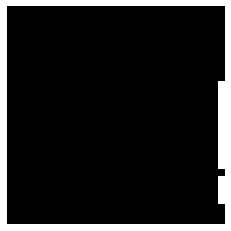

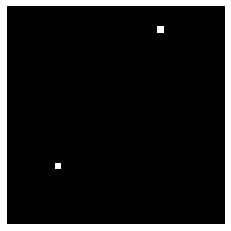

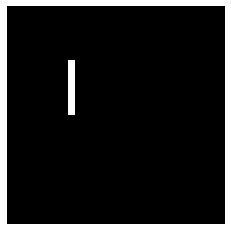

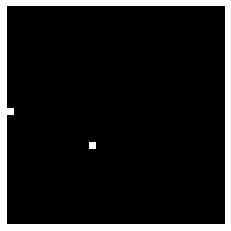

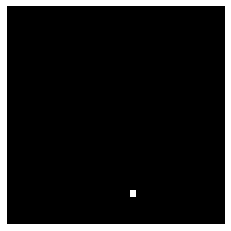

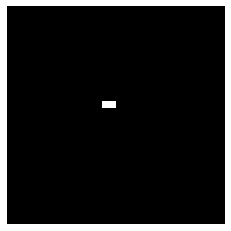

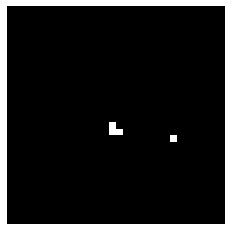

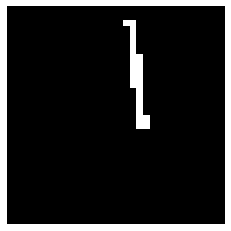

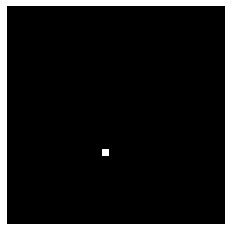

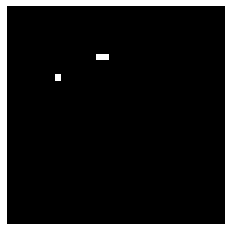

In [6]:
## Visualize the data
def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(img_data[i])

## SVM Classifier

In [7]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        loss += .5*np.dot(W,W.T)
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))      
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        self.W = W
        self.b = bias
        return W,bias,losses

In [8]:
## Data conversion for One vs One classification
M = img_data.shape[0]
img_data = img_data.reshape(M,-1)
print(img_data.shape)
print(labels.shape)

(2093, 3072)
(2093,)


In [9]:
number_of_classes = len(np.unique(labels))

In [10]:
def classWiseData(x, y):
    data = {}
    
    for i in range(number_of_classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [11]:
data = classWiseData(img_data, labels)

In [12]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])

684
849
560


In [13]:
"""Combines data of two classes into a single matrix"""
def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair, data_labels

## Training nC2 SVM

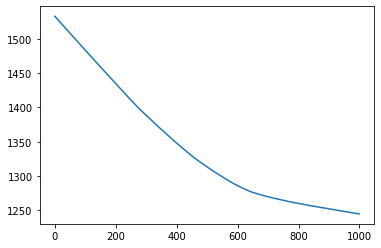

In [14]:
mySVM = SVM()
xp, yp = getDataPairForSVM(data[0], data[1])
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)

In [15]:
def trainSVMs(x,y):
    svm_classifiers = {}
    
    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers

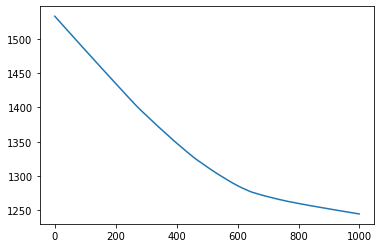

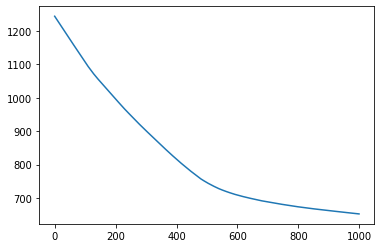

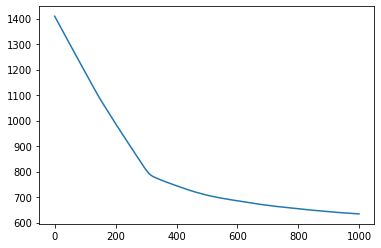

In [16]:
svm_classifiers = trainSVMs(img_data, labels)

In [17]:
multiple_single = svm_classifiers[0][1]
multiple_straight = svm_classifiers[0][2]
print(multiple_single[0].shape)
print(multiple_single[1])

(1, 3072)
0.9540300000000023


## Prediction

In [18]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

In [19]:
def predict(x):
    count = np.zeros((number_of_classes,))
    
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            
            #Take a majority prediction
            z = binaryPredict(x,w,b)
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    return final_prediction

In [20]:
print(predict(img_data[0]))
print(labels[0])

2
2


In [21]:
def accuracy(x,y):
    pred = []
    count=0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    
    return count/x.shape[0], pred

In [22]:
acc, ypred = accuracy(img_data, labels)
print(acc)

0.52269469660774


## Using scikit

In [23]:
from sklearn import svm

In [24]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(img_data, labels)
ypred_sklearn = svm_classifier.predict(img_data)
svm_classifier.score(img_data,labels)

0.6731963688485427

## Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### SVM classifier

In [27]:
cnf_matrix = confusion_matrix(labels, ypred)
print(cnf_matrix)

[[ 11 546 127]
 [  2 735 112]
 [  9 203 348]]


Confusion matrix, without normalization
[[ 11 546 127]
 [  2 735 112]
 [  9 203 348]]


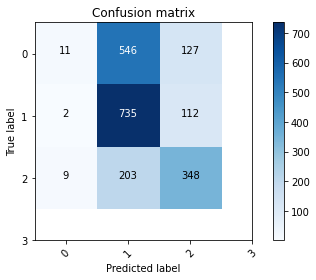

In [28]:
plot_confusion_matrix(cnf_matrix, [0,1,2,3],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)

### Sci-kit Learn

In [29]:
cnf_matrix_sklearn = confusion_matrix(labels, ypred_sklearn)
print(cnf_matrix_sklearn)

[[281 211 192]
 [ 62 604 183]
 [ 13  23 524]]


Confusion matrix, without normalization
[[281 211 192]
 [ 62 604 183]
 [ 13  23 524]]


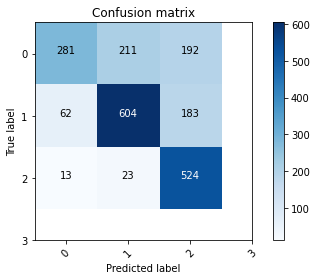

In [30]:
plot_confusion_matrix(cnf_matrix_sklearn, [0,1,2,3],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)